<a href="https://colab.research.google.com/github/gopalaniyengar/ITSP_BigBrainTeam_CNN/blob/Gopalan/ITSP_Proj_MK2_Part_2w/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
/pwd


'/content'

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import sklearn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [0]:
transform=transforms.ToTensor()
trainset=datasets.EMNIST(root='/content/drive/My Drive/Colab Notebooks/data', split= 'byclass', train=True, download=True, transform=transform)
testset=datasets.EMNIST(root='/content/drive/My Drive/Colab Notebooks/data', split= 'byclass', train=False, download=True, transform=transform)
print(len(trainset))
print(len(testset))
print(len(trainset)+len(testset))
print(1)  

697932
116323
814255
1


In [0]:
batch=32
numberofbatches=697932/32
print(numberofbatches)
numberofbatches=21811
print(numberofbatches)
trainloadeddata=DataLoader(trainset, batch_size=batch, shuffle= True)
testloadeddata=DataLoader(testset, batch_size=batch, shuffle= True)
#for batchno,(image, labels) in enumerate(trainloadeddata):
    #if  batchno==1:
     #print(image, labels)

21810.375
21811


In [0]:
class ModelOfNet(nn.Module):
    def __init__(self):
        super(ModelOfNet,self).__init__()

        self.convolve=nn.Sequential(
                nn.Conv2d(1,8,3,1,1),
                nn.ReLU(),
                nn.Conv2d(8,16,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.MaxPool2d(2,2),
                nn.Conv2d(16,32,3,1,1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2,2),
        )
        self.fullyconnect=nn.Linear(1568,62)

    def forward(self, x):
        x=self.convolve(x)
        x=x.view(x.size(0),-1)
        x=self.fullyconnect(x)
        return x 
    print('I sure hope this model works fine this time without any errors')

I sure hope this model works fine this time without any errors


In [0]:
MYNN=ModelOfNet()
print(MYNN)
classwts=torch.load('/content/drive/My Drive/Colab Notebooks/lossweights.pt')
print(classwts)
print(classwts.dtype)
lossfunction=torch.nn.CrossEntropyLoss(weight=classwts)
updatefunction=torch.optim.Adam(MYNN.parameters(), lr=0.00001)
print('completed running block')

ModelOfNet(
  (convolve): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyconnect): Linear(in_features=1568, out_features=62, bias=True)
)
tensor([0.3255, 0.2933, 0.3291, 0.3203, 0.3357, 0.3583, 0.3288, 0.3148, 0.3316,
        0.3326, 1.7570, 2.9028, 1.1152, 2.4676, 2.2815, 1.2260, 4.4724, 3.5714,
        0.9423, 2.9923, 4.5612, 2.2177, 1.2505, 1.3666, 0.4506, 1.3486, 4.3213,
        2.2190, 0.5421, 1.146

In [0]:
def validationtrainingtime(epochs):
  avglossoverepochs=[]
  accuracyoverepochs=[]
  validationaccuracyoverepochs=[]
  for i in range(epochs):
    sum=0.0
    avgaccuracyoverepoch=0.0
    sumbatch=0.0
    for batchno,(image, labels) in enumerate(trainloadeddata):

      updatefunction.zero_grad()
      resultofmodel=MYNN(image)
      losscalc=lossfunction(resultofmodel, labels)
      resultofmodel=F.softmax(resultofmodel, dim=1)
      #print(resultofmodel.shape)
      pred=torch.argmax(resultofmodel, dim=1)
      #print(pred)
      
      count=0.0
      assert pred.shape[0]==labels.shape[0]
      for j in range(pred.shape[0]):
        if pred[j]==labels[j]:
          count=count+1.0
      
      batchaccuracy=(count/pred.shape[0])*100
      sum=sum+losscalc
      sumbatch=sumbatch+losscalc
      losscalc.backward()
      updatefunction.step()

      if batchno%1000==True:
        print(i, batchno, "Batch Loss:", losscalc,"Batch Accuracy=", batchaccuracy,"%", "Average Loss Over 1000 Batches:", (sumbatch/1000))
        sumbatch=0.0
      avgaccuracyoverepoch=avgaccuracyoverepoch+(batchaccuracy/numberofbatches)
      if batchno==17500:
        break

    print("Average Loss over Epoch:", (sum/numberofbatches))
    print("Average Accuracy over Epoch:", avgaccuracyoverepoch, "%")
    accuracyoverepochs.append(avgaccuracyoverepoch)
    avglossoverepochs.append((sum/numberofbatches))
    avgvalidationaccuracyoverepoch=0.0
    for batchno2,(image2,labels2) in enumerate(trainloadeddata):
      if batchno2>17500:  
        with torch.no_grad():
            resultofmodel2=MYNN(image2)
            losscalc2=lossfunction(resultofmodel2, labels2)
            resultofmodel2=F.softmax(resultofmodel2, dim=1)
            #print(resultofmodel2.shape)
            pred2=torch.argmax(resultofmodel2, dim=1)
            #print(pred2)
            
            count2=0.0
            assert pred2.shape[0]==labels2.shape[0]
            for k in range(pred2.shape[0]):
              if pred2[k]==labels2[k]:
                count2=count2+1.0
            batchaccuracy2=(count2/pred2.shape[0])*100

            if batchno2%100==True:
              print(i, batchno2, "Batch Validation Accuracy=", batchaccuracy2, "%")
            avgvalidationaccuracyoverepoch=avgvalidationaccuracyoverepoch+(batchaccuracy2/(numberofbatches-17500))

    print("Average Validation Accuracy over Epoch=", avgvalidationaccuracyoverepoch)
    validationaccuracyoverepochs.append(avgvalidationaccuracyoverepoch)  
  print('hopefully i reach this part of the function')
  print(accuracyoverepochs)
  print(avglossoverepochs)
  print(validationaccuracyoverepochs) 

In [0]:
epoch=10
validationtrainingtime(epoch)

0 1 Batch Loss: tensor(4.6991, grad_fn=<NllLossBackward>) Batch Accuracy= 6.25 % Average Loss Over 1000 Batches: tensor(0.0091, grad_fn=<DivBackward0>)
0 1001 Batch Loss: tensor(2.8916, grad_fn=<NllLossBackward>) Batch Accuracy= 56.25 % Average Loss Over 1000 Batches: tensor(3.6417, grad_fn=<DivBackward0>)
0 2001 Batch Loss: tensor(2.3244, grad_fn=<NllLossBackward>) Batch Accuracy= 40.625 % Average Loss Over 1000 Batches: tensor(2.6394, grad_fn=<DivBackward0>)
0 3001 Batch Loss: tensor(1.5741, grad_fn=<NllLossBackward>) Batch Accuracy= 65.625 % Average Loss Over 1000 Batches: tensor(2.1155, grad_fn=<DivBackward0>)
0 4001 Batch Loss: tensor(1.9647, grad_fn=<NllLossBackward>) Batch Accuracy= 56.25 % Average Loss Over 1000 Batches: tensor(1.8505, grad_fn=<DivBackward0>)
0 5001 Batch Loss: tensor(1.6776, grad_fn=<NllLossBackward>) Batch Accuracy= 56.25 % Average Loss Over 1000 Batches: tensor(1.6322, grad_fn=<DivBackward0>)
0 6001 Batch Loss: tensor(1.3298, grad_fn=<NllLossBackward>) Batch

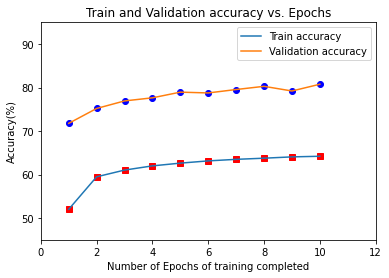

In [34]:
accvepochs=[52.014321901782026, 59.48618243086869, 61.03012814633291, 61.99838957405281, 62.629091971925206, 63.14517330703163, 63.50092843059306, 63.76541653292685, 64.06715648065976, 64.20900004583375]
validationaccvepochs=[71.7781063944944, 75.19982795948391, 76.93303951132802, 77.64778087064188, 78.95330743060491, 78.76942704708964, 79.55689901801705, 80.2895209928102, 79.21813384365682, 80.77157272094776]
plt.plot([1,2,3,4,5,6,7,8,9,10],accvepochs,'rs')
plt.plot([1,2,3,4,5,6,7,8,9,10],validationaccvepochs,'bo')
plt.plot([1,2,3,4,5,6,7,8,9,10],accvepochs,label='Train accuracy')
plt.plot([1,2,3,4,5,6,7,8,9,10],validationaccvepochs,label='Validation accuracy')
plt.axis([0,12,45,95])
plt.xlabel('Number of Epochs of training completed')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.title('Train and Validation accuracy vs. Epochs')
plt.show()

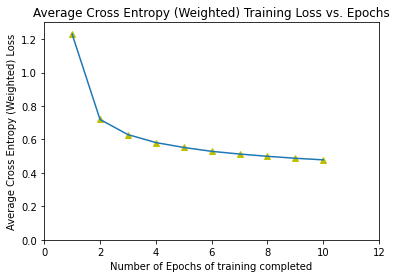

In [39]:
lossperepoch=[1.2302,0.7196,0.6291,0.5814,0.5521,0.5290,0.5128,0.4993,0.4875,0.4780,]
#print(lossperepoch)
plt.plot([1,2,3,4,5,6,7,8,9,10], lossperepoch, 'y^')
plt.plot([1,2,3,4,5,6,7,8,9,10], lossperepoch)
plt.xlabel('Number of Epochs of training completed')
plt.ylabel('Average Cross Entropy (Weighted) Loss')
plt.axis([0,12,0,1.3])
plt.title('Average Cross Entropy (Weighted) Training Loss vs. Epochs')
plt.show()